In [1]:
import os
import urllib2
import pyart
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import num2date, date2num
import time

%matplotlib inline

/home/scollis/anaconda/lib/python2.7/site-packages/ipykernel/pylab/config.py:66: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  inline backend."""
/home/scollis/anaconda/lib/python2.7/site-packages/ipykernel/pylab/config.py:71: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  'retina', 'jpeg', 'svg', 'pdf'.""")
/home/scollis/anaconda/lib/python2.7/site-packages/ipykernel/pylab/config.py:85: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  use `figure_formats` instead)""")
/home/scollis/anaconda/lib/python2.7/site-packages/ipykernel/pylab/config.py:95: DeprecationWarning: metadata {'config': True} was set from the const

In [2]:
def get_88d(radarID):
    d_fmt = "%Y-%m-%d %H:%M"
    dout_fmt = "%Y-%m-%d_%H:%M"        
    SERVICE = "http://nomads.ncep.noaa.gov/pub/data/nccf/radar/nexrad_level2"
    nexurl = '%s/%s/'%(SERVICE, radarID)
    response = urllib2.urlopen("%s%s"%(nexurl, "dir.list"))
    list88D = response.read().split("\n")

    # At this point you have a list of data files, BUT there are 2 columns
    # col 1 = file size, col2 = filename

    # Now grab the latest data file and save it locally to open
    #print list88D
    print("%s%s"%(nexurl,list88D[-3].split(" ")[1]))
    data = urllib2.urlopen("%s%s"%(nexurl,list88D[-3].split(" ")[1]))
    
    with open("latest88D.bz", "wb") as code:
        code.write(data.read())
    return pyart.io.read_nexrad_archive("latest88D.bz")

def get_and_append_rainfall(radarID):
    radar = get_88d(radarID)
    rain_z = radar.fields['reflectivity']['data'].copy()
    z_lin = 10.0**(radar.fields['reflectivity']['data']/10.)
    rain_z = (z_lin/300.0)**(1./1.4)  #Z=300 R1.4
    radar.add_field_like('reflectivity', 'rain_z',  rain_z, replace_existing = True)
    radar.fields['rain_z']['units'] = 'mm/h'
    radar.fields['rain_z']['standard_name'] = 'rainfall_rate'
    radar.fields['rain_z']['long_name'] = 'rainfall_rate_from_z'
    radar.fields['rain_z']['valid_min'] = 0
    radar.fields['rain_z']['valid_max'] = 500
    return radar

def regional_display(radar_names, odir):
    myradars = []
    goods = []
    for namer in radar_names:
        try:
            myradars.append(get_and_append_rainfall(namer))
            goods.append(namer)
        except:
            print('damn '+ namer)
    gatefilters = []
    for this_radar in myradars:
        gatefilter = pyart.correct.GateFilter(this_radar)
        gatefilter.exclude_masked('reflectivity')
        gatefilter.exclude_below('rain_z', 0.0)
        gatefilter.exclude_below('reflectivity', -40)

        gatefilter.exclude_above('reflectivity', 80)

        gatefilters.append(gatefilter)
    #gatefilter.exclude_below('cross_correlation_ratio', 0.75)
    grid = pyart.map.grid_from_radars(
         myradars, grid_shape=(1, 501, 501),
        grid_limits=((0, 0),(-500000, 500000), (-500000, 500000)),
        fields=['reflectivity', 'rain_z'], gridding_algo="map_gates_to_grid",
        weighting_function='BARNES', gatefilters = gatefilters)
    dts = num2date(grid.axes['time']['data'], grid.axes['time']['units'])
    sstr = dts[0].strftime('%Y%m%d_%H%M%S')
    #pyart.io.write_grid(md + 'grid_250_'+sstr+'.nc', grid)
    max_lat = 50
    min_lat = 30
    min_lon = -100
    max_lon = -70

    figme = plt.figure(figsize = [15,15])
    display = pyart.graph.GridMapDisplay(grid)
    display.plot_basemap(lat_lines=np.arange(min_lat,max_lat,1),
                         lon_lines=np.arange(min_lon, max_lon, 1),
                         resolution='h')
    display.plot_grid('reflectivity', vmin=-8, vmax=64)
    xcf,ycf = display.basemap(-87.9706,41.6815)
    display.basemap.plot(xcf,ycf,'ro')
    plt.text(xcf+2000.,ycf+2000., 'Argonne Lab')
    for i  in range(len(myradars)):
        xcf,ycf = display.basemap(myradars[i].longitude['data'][0], myradars[i].latitude['data'][0])
        display.basemap.plot(xcf,ycf,'ro')
        plt.text(xcf+2000.,ycf+2000.,goods[i])
    display.basemap.drawcounties()
    display.basemap.drawrivers()
    display.basemap.drawmapscale(-88., 37.55, -88., 37.55, 100, 
                                 barstyle='fancy', fontcolor='k', 
                                 fillcolor1='b', fillcolor2='k')
    plt.savefig(odir + 'regional_reflectivity_'+sstr+'.png')
    plt.close(figme)
    figme = plt.figure(figsize = [15,15])
    display = pyart.graph.GridMapDisplay(grid)
    display.plot_basemap(lat_lines=np.arange(min_lat,max_lat,1),
                         lon_lines=np.arange(min_lon, max_lon, 1),
                         resolution='h')
    display.plot_grid('rain_z', vmin=0, vmax=64)
    xcf,ycf = display.basemap(-87.9706,41.6815)
    display.basemap.plot(xcf,ycf,'ro')
    plt.text(xcf+2000.,ycf+2000., 'Argonne Lab')
    for i  in range(len(myradars)):
        xcf,ycf = display.basemap(myradars[i].longitude['data'][0], myradars[i].latitude['data'][0])
        display.basemap.plot(xcf,ycf,'ro')
        plt.text(xcf+2000.,ycf+2000.,goods[i])

    display.basemap.drawcounties()
    display.basemap.drawrivers()
    display.basemap.drawmapscale(-88., 37.55, -88., 37.55, 100, 
                                 barstyle='fancy', fontcolor='k', 
                                 fillcolor1='b', fillcolor2='k')
    plt.savefig(odir + 'regional_rainfall_'+sstr+'.png')
    del myradars
    plt.close(figme)
    

In [71]:
test = get_and_append_rainfall('KIND')

http://nomads.ncep.noaa.gov/pub/data/nccf/radar/nexrad_level2/KIND/KIND_20160324_144713.bz2


In [36]:
radar_names = ('KLOT', 'KILX', 'KDVN', 'KMKX', 'KGRB')
myradars = [get_and_append_rainfall(radarID) for radarID in radar_names]


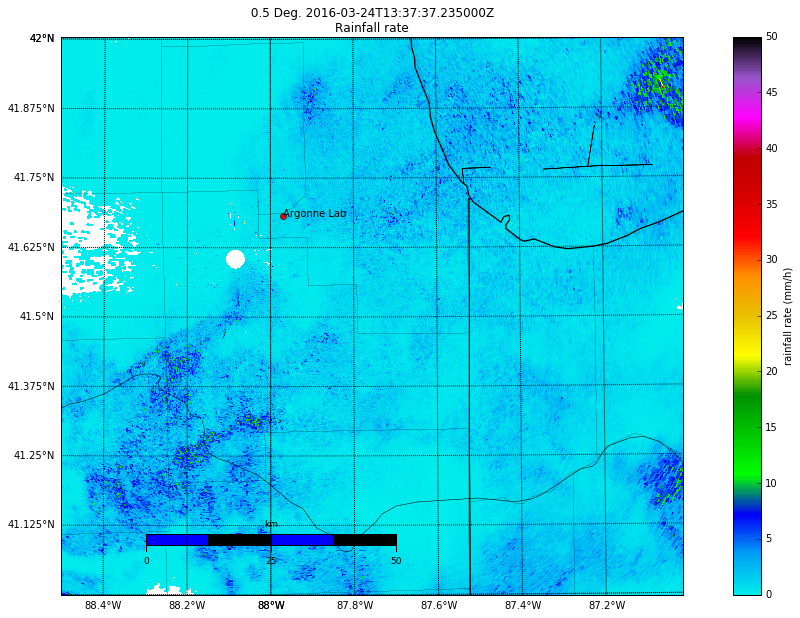

In [17]:
myd = pyart.graph.RadarMapDisplay(myradars[0])
fig = plt.figure(figsize = [18,10])
myd.plot_ppi_map( 'rain_z', vmin = 0, vmax = 50, 
                 resolution = 'h', max_lat = 42, 
                 min_lat = 41, min_lon = -88.5, max_lon = -87,
                 cmap='pyart_NWSRef')
m = myd.basemap
m.drawparallels(np.linspace(41, 42, 9),labels=[1,0,0,0])
m.drawmeridians(np.linspace(-88.4, -87, 8),labels=[0,0,0,1])
m.drawrivers()
m.drawcounties()
m.drawstates()
m.drawmapscale(-88., 41.1, -88., 41.1, 50, barstyle='fancy', fontcolor='k', fillcolor1='b', fillcolor2='k')
myd.plot_point( -87.9706,41.6815, label_text = 'Argonne Lab', label_offset = (0.0,0.0) )



In [38]:
gatefilters = []
for this_radar in myradars:
    gatefilter = pyart.correct.GateFilter(this_radar)
    gatefilter.exclude_masked('reflectivity')
    gatefilters.append(gatefilter)
#gatefilter.exclude_below('cross_correlation_ratio', 0.75)
grid = pyart.map.grid_from_radars(
     myradars, grid_shape=(1, 501, 501),
    grid_limits=((0, 0),(-500000, 500000), (-500000, 500000)),
    fields=klot.fields.keys(), gridding_algo="map_gates_to_grid",
    weighting_function='BARNES', gatefilters = gatefilters)
dts = num2date(grid.axes['time']['data'], grid.axes['time']['units'])
sstr = dts[0].strftime('%Y%m%d_%H%M%S')
#pyart.io.write_grid(md + 'grid_250_'+sstr+'.nc', grid)


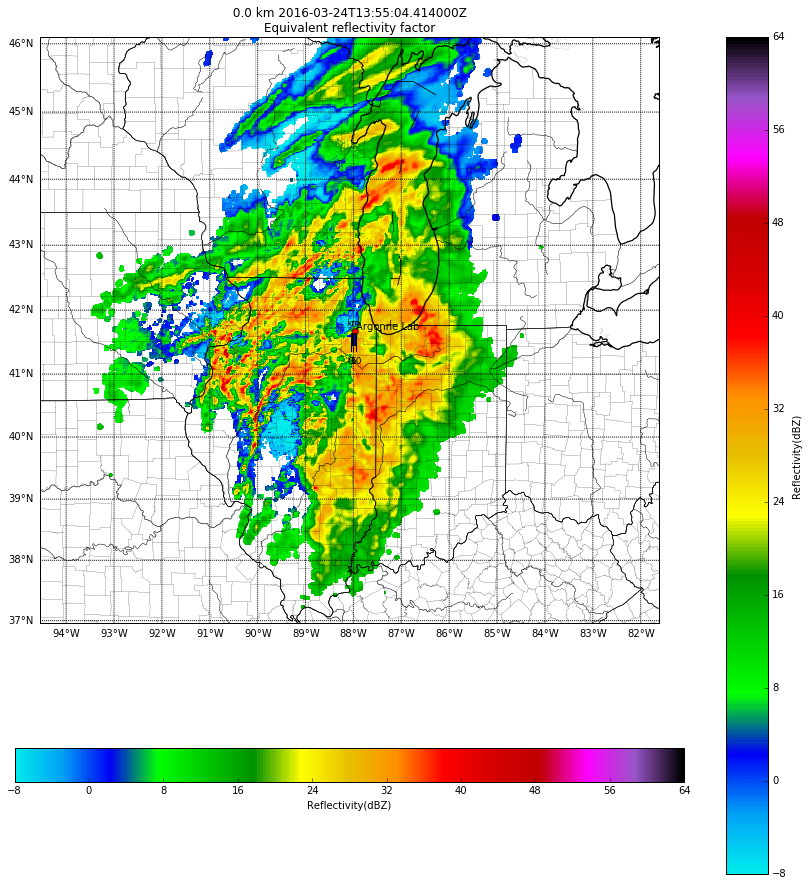

In [39]:
max_lat = 50
min_lat = 30
min_lon = -100
max_lon = -70

plt.figure(figsize = [15,15])
display = pyart.graph.GridMapDisplay(grid)
display.plot_basemap(lat_lines=np.arange(min_lat,max_lat,1),
                     lon_lines=np.arange(min_lon, max_lon, 1),
                     resolution='h')
display.plot_grid('reflectivity', vmin=-8, vmax=64)
xcf,ycf = display.basemap(-87.9706,41.6815)
display.basemap.plot(xcf,ycf,'ro')
plt.text(xcf+2000.,ycf+2000., 'Argonne Lab')
display.basemap.drawcounties()
display.basemap.drawrivers()
display.basemap.drawmapscale(-88., 41.55, -88., 41.55, 10, 
                             barstyle='fancy', fontcolor='k', 
                             fillcolor1='b', fillcolor2='k')
display.plot_colorbar()

In [ ]:
radar_names = ('KLOT', 'KILX', 'KDVN', 
               'KMKX', 'KGRB', 'KIWX', 
               'KIND', 'KLSX', 'KDMX', 
               'KLVX')

myradars = []
for namer in radar_names:
    try:
        myradars.append(get_and_append_rainfall(namer))
    except:
        print('damn '+ namer)

http://nomads.ncep.noaa.gov/pub/data/nccf/radar/nexrad_level2/KLOT/KLOT_20160324_160504.bz2
http://nomads.ncep.noaa.gov/pub/data/nccf/radar/nexrad_level2/KILX/KILX_20160324_160912.bz2
http://nomads.ncep.noaa.gov/pub/data/nccf/radar/nexrad_level2/KDVN/KDVN_20160324_160934.bz2

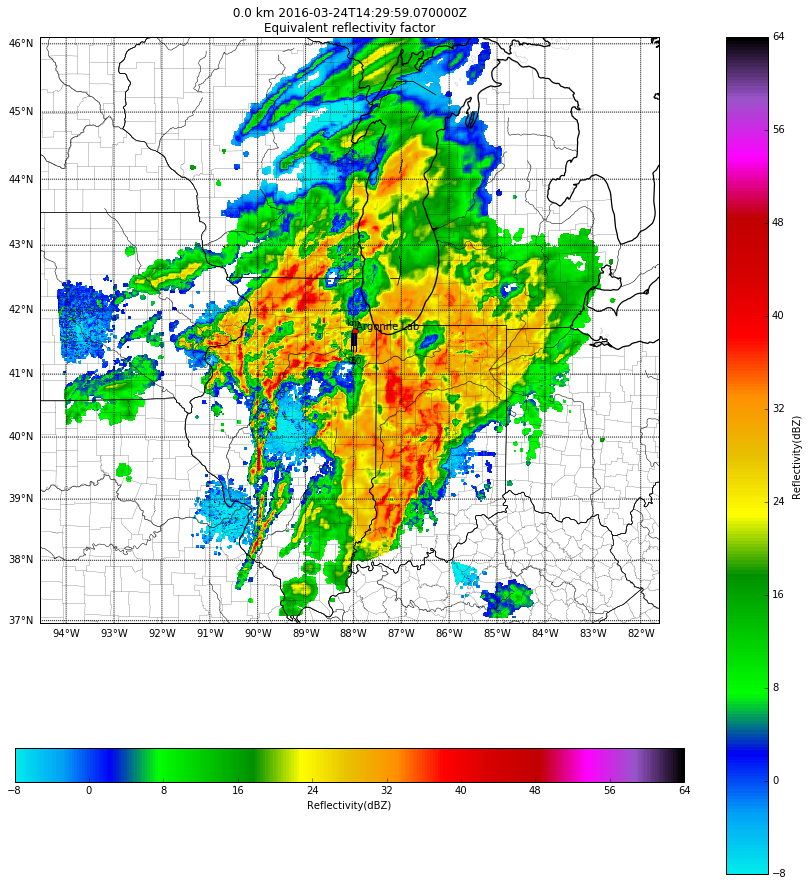

In [48]:
gatefilters = []
for this_radar in myradars:
    gatefilter = pyart.correct.GateFilter(this_radar)
    gatefilter.exclude_masked('reflectivity')
    gatefilter.exclude_below('rain_z', 0.0)
    gatefilter.exclude_below('reflectivity', -40)
    
    gatefilter.exclude_above('reflectivity', 80)
    
    gatefilters.append(gatefilter)
#gatefilter.exclude_below('cross_correlation_ratio', 0.75)
grid = pyart.map.grid_from_radars(
     myradars, grid_shape=(1, 501, 501),
    grid_limits=((0, 0),(-500000, 500000), (-500000, 500000)),
    fields=['reflectivity', 'rain_z'], gridding_algo="map_gates_to_grid",
    weighting_function='BARNES', gatefilters = gatefilters)
dts = num2date(grid.axes['time']['data'], grid.axes['time']['units'])
sstr = dts[0].strftime('%Y%m%d_%H%M%S')
#pyart.io.write_grid(md + 'grid_250_'+sstr+'.nc', grid)
max_lat = 50
min_lat = 30
min_lon = -100
max_lon = -70

plt.figure(figsize = [15,15])
display = pyart.graph.GridMapDisplay(grid)
display.plot_basemap(lat_lines=np.arange(min_lat,max_lat,1),
                     lon_lines=np.arange(min_lon, max_lon, 1),
                     resolution='h')
display.plot_grid('reflectivity', vmin=-8, vmax=64)
xcf,ycf = display.basemap(-87.9706,41.6815)
display.basemap.plot(xcf,ycf,'ro')
plt.text(xcf+2000.,ycf+2000., 'Argonne Lab')
display.basemap.drawcounties()
display.basemap.drawrivers()
display.basemap.drawmapscale(-88., 41.55, -88., 41.55, 10, 
                             barstyle='fancy', fontcolor='k', 
                             fillcolor1='b', fillcolor2='k')
display.plot_colorbar()

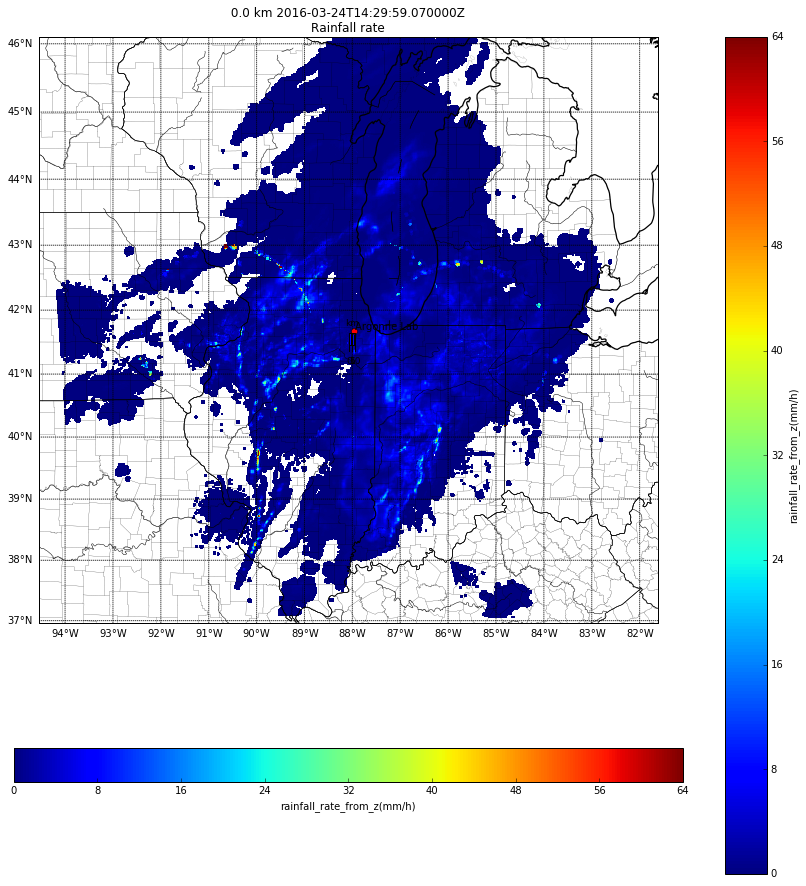

In [49]:

plt.figure(figsize = [15,15])
display = pyart.graph.GridMapDisplay(grid)
display.plot_basemap(lat_lines=np.arange(min_lat,max_lat,1),
                     lon_lines=np.arange(min_lon, max_lon, 1),
                     resolution='h')
display.plot_grid('rain_z', vmin=0, vmax=64)
xcf,ycf = display.basemap(-87.9706,41.6815)
display.basemap.plot(xcf,ycf,'ro')
plt.text(xcf+2000.,ycf+2000., 'Argonne Lab')
display.basemap.drawcounties()
display.basemap.drawrivers()
display.basemap.drawmapscale(-88., 41.55, -88., 41.55, 10, 
                             barstyle='fancy', fontcolor='k', 
                             fillcolor1='b', fillcolor2='k')
display.plot_colorbar()

In [3]:
radar_names = ('KLOT', 'KILX', 'KDVN', 
               'KMKX', 'KGRB', 'KIWX', 
               'KIND', 'KLSX', 'KDMX', 
               'KLVX', 'KGRR', 'KDTX',
               'KCLE', 'KMPX', 'KARX',
               'KDMX', 'KSGF', 'KILN',
               'KAPX', 'KJKL', 'KDLH')

#regional_display(radar_names, '/home/scollis/regionals/')

In [ ]:
for i in range(100):
    regional_display(radar_names, '/home/scollis/regionals/')
    #time.sleep(5*60)

http://nomads.ncep.noaa.gov/pub/data/nccf/radar/nexrad_level2/KLOT/KLOT_20160324_182803.bz2
http://nomads.ncep.noaa.gov/pub/data/nccf/radar/nexrad_level2/KILX/KILX_20160324_182818.bz2
http://nomads.ncep.noaa.gov/pub/data/nccf/radar/nexrad_level2/KDVN/KDVN_20160324_182016.bz2
http://nomads.ncep.noaa.gov/pub/data/nccf/radar/nexrad_level2/KMKX/KMKX_20160324_182629.bz2
http://nomads.ncep.noaa.gov/pub/data/nccf/radar/nexrad_level2/KGRB/KGRB_20160324_182034.bz2
http://nomads.ncep.noaa.gov/pub/data/nccf/radar/nexrad_level2/KIWX/KIWX_20160324_161000.bz2